In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from time import time
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score as f1_score_rep
from sklearn.metrics import accuracy_score

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import SimpleRNN, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

/tmp/ipykernel_982/519576303.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-12 04:16:12.685143: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-12 04:16:12.721853: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 04:16:12.721919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cu

In [2]:
x_test = np.load('/home/jovyan/MQTTset/x_test.npy')
x_train = np.load('/home/jovyan/MQTTset/x_train.npy')
x_val = np.load('/home/jovyan/MQTTset/x_val.npy')
y_test = np.load('/home/jovyan/MQTTset/y_test.npy')
y_train = np.load('/home/jovyan/MQTTset/y_train.npy')
y_val = np.load('/home/jovyan/MQTTset/y_val.npy')

In [3]:
timesteps = 1 # Number of timesteps; adjust based on your data
features_per_timestep = x_train.shape[1] # Features per timestep
x_train = x_train.reshape(-1, timesteps, features_per_timestep)
x_val = x_val.reshape(-1, timesteps, features_per_timestep)
x_test = x_test.reshape(-1, timesteps, features_per_timestep)

input_shape = x_train.shape[1:]
num_classes = len(np.unique(y_train))


rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, return_sequences=True, input_shape=input_shape))
rnn_model.add(SimpleRNN(50))
rnn_model.add(Dense(units=30, activation='relu'))
rnn_model.add(Dense(units=num_classes, activation='softmax'))

# rnn_model = Sequential()
# rnn_model.add(SimpleRNN(100, return_sequences=True, input_shape=input_shape))
# rnn_model.add(SimpleRNN(100))
# rnn_model.add(Dense(units=70, activation='relu'))
# rnn_model.add(Dense(units=num_classes, activation='softmax'))



opt = SGD(learning_rate=0.01)

rnn_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
hist = rnn_model.fit(x_train, y_train, epochs=5, batch_size=128,
                     validation_data=(x_val, y_val), # 使用 x_val 和 y_val 作为验证数据
                     callbacks=[early_stopping])

test_loss, test_acc = rnn_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

y_hat = rnn_model.predict(x_test)
y_hat = np.argmax(y_hat, axis=-1)

2024-02-12 04:16:41.023972: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/5
56159/56159 [==============================] - 74s 1ms/step - loss: 0.0686 - accuracy: 0.9886 - val_loss: 0.0810 - val_accuracy: 0.9863
Epoch 2/5
56159/56159 [==============================] - 73s 1ms/step - loss: 0.0788 - accuracy: 0.9866 - val_loss: 0.0839 - val_accuracy: 0.9863
Epoch 3/5
56159/56159 [==============================] - 70s 1ms/step - loss: 0.0799 - accuracy: 0.9863 - val_loss: 0.0807 - val_accuracy: 0.9863
Epoch 4/5
56159/56159 [==============================] - 71s 1ms/step - loss: 0.0797 - accuracy: 0.9863 - val_loss: 0.0807 - val_accuracy: 0.9863
Epoch 5/5
113262/113262 [==============================] - 80s 704us/step - loss: 0.0813 - accuracy: 0.9863
Test accuracy: 0.9863148331642151
113262/113262 [==============================] - 70s 617us/step


113262/113262 [==============================] - 70s 617us/step
FPR: [0.00000000e+00 1.11567017e-06 0.00000000e+00 9.98892268e-01
 0.00000000e+00 0.00000000e+00]
TPR: [0.         0.00130512 0.         1.         0.         0.        ]
FNR: [1.         0.99869488 1.         0.         1.         1.        ]
TNR: [1.         0.99999888 1.         0.00110773 1.         1.        ]
Precision: 0.3189314118579847
Accuracy: 0.9863148478933971
F1-score: 0.16595288285105617
AUC: 0.5523589962687914
FPR: 0.16648223061683812
tpr: 0.16688418592351853
fnr: 0.8331158140764815
tnr: 0.8335177693831618


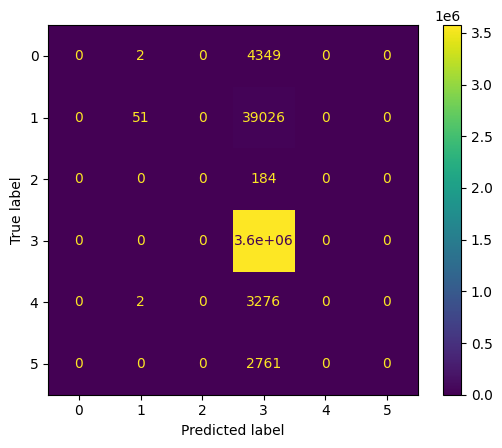

In [4]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, f1_score, roc_auc_score



conf_matrix = confusion_matrix(y_test, y_hat)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)


fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test, y_hat, average='macro')
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='macro')
auc = roc_auc_score(y_test, rnn_model.predict(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

import pandas as pd
metrics = {
    "model" : "rnn",
    "Accuracy": accuracy,
    "Precision": precision,
    "F1-score": f1,
    "FPR": np.mean(fpr),
    "TPR": np.mean(tpr),
    "FNR": np.mean(fnr),
    "TNR": np.mean(tnr),
    "AUC": auc
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("/home/jovyan/MQTTset/model.csv", mode='a', index=False)